# Vortex Plots

Integrative analysis across Naive and Primed hESC specific peaks from GSE101074, plus TFAP2C dependent peaks.

**Inputs:**
1. List of peak sets
2. Config of samples, bigwig path and class of sample (each class will have same plot styling). If sample belongs to ATAC dataset, old cluster ID else NA.
3. For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)

In [46]:
library(ggplot2)
library(patchwork)
library(reshape2)
library(rtracklayer)
library(scales)
library(viridis)
library(matrixStats)
library(ggrastr)
library(raster)

## Loading Inputs

### Configs

In [92]:
vortex_config = read.table("./configs/vortex_tracks_config.tsv", sep='\t', header=T)
vortex_config$title = factor(vortex_config$title, levels= unique(vortex_config$title))
vortex_config$path = as.character(vortex_config$path)
vortex_config$type = factor(vortex_config$type,
                           levels=unique(vortex_config$type))
vortex_config

title,old_cluster,type,group,width,path
<fct>,<int>,<fct>,<int>,<int>,<chr>
Fibroblast,5,ATAC,1,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx5/signal/rep1/cluster_idx5.fc.signal.bigwig
Fibroblast,NA,H3K4me2,1,4000,/oak/stanford/groups/akundaje/surag/GEO/GSE62777/croo/hiF-T_P15_H3K4me2/signal/pooled-rep/basename_prefix.pooled_x_SRR2106008.nodup.fc.signal.bigwig
MRC5 (CC),NA,ATAC3,1,2000,/oak/stanford/groups/akundaje/projects/heterokaryon/ATAC-Seq/Batch1/outputs/CC_hg38/cromwell-executions/atac/8a3ac2dd-002d-41c5-88d6-a8c0787309dd/call-macs2_signal_track/shard-0/execution/CC_rep1.R1.merged.nodup.bam.hg38.renamed.tn5.fc.signal.bigwig
Early Intermediate,14,ATAC,2,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx14/signal/rep1/cluster_idx14.fc.signal.bigwig
OCT4,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445816/signal/rep1/SRR445816.filt_x_ctl_for_rep1.fc.signal.bigwig
SOX2,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445817/signal/rep1/SRR445817.filt_x_ctl_for_rep1.fc.signal.bigwig
KLF4,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445818/signal/rep1/SRR445818.filt_x_ctl_for_rep1.fc.signal.bigwig
cMYC,NA,ChIP,2,2000,/oak/stanford/groups/akundaje/surag/GEO/GSE36570/croo/SRR445819/signal/rep1/SRR445819.filt_x_ctl_for_rep1.fc.signal.bigwig
Intermediate,1,ATAC,3,2000,/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/clusters/20200518_n76052/croo/cluster_idx1/signal/rep1/cluster_idx1.fc.signal.bigwig


In [93]:
peak_set_config = read.table("./configs/vortex_peak_set_config.tsv", stringsAsFactors = F, comment.char = '', sep='\t', header=T)
peak_set_config

title,group,path
<chr>,<int>,<chr>
TFAP2C.dependent.naive.specific,1,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/TFAP2C.dependent.reg.elements.hg38.bed
naive.specific,2,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/naive.specific.atac.hg38.bed
primed.specific,2,/users/surag/kundajelab/scATAC-reprog/resources/GSE101074/primed.specific.atac.hg38.bed


### Peak Sets

In [94]:
peak_sets = list()
SUBSAMPLE = 4

for (i in seq(nrow(peak_set_config))) {
    peak_sets[[i]] = import(peak_set_config[i, "path"])
    peak_sets[[i]] = peak_sets[[i]][seq(1,length(peak_sets[[i]]),SUBSAMPLE)]
}

In [95]:
peak_set_lens = list()

for (i in seq(length(peak_sets))) {
    peak_set_lens[[i]] = length(peak_sets[[i]])
}

peak_set_lens

sum(unlist(peak_set_lens))

[[1]]
[1] 390

[[2]]
[1] 1258

[[3]]
[1] 641

[1] 2289

### Fetch Data from BigWigs

In [96]:
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [97]:
matrices = list()

In [98]:
for (i in seq(length(peak_sets))) {
    matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = get_matrix_from_bigwig(vortex_config[j, "path"], 
                                                    resize(peak_sets[[i]], width=vortex_config[j, "width"], fix='center'))
    }
}

## Compute Orders for Each Peak Set and Reorder

In [99]:
# samples which will be used to decide peak order (based on mean signal across all)
ROW_ORDER_TYPE = "ATAC"

In [100]:
peak_set_orders = list()

In [101]:
for (i in seq(length(peak_sets))) {
    tmp_matrix = do.call(cbind, matrices[[i]][vortex_config$type %in% ROW_ORDER_TYPE])
    peak_set_orders[[i]] = order(rowSums(tmp_matrix))
}

In [102]:
rm(tmp_matrix)

In [103]:
peak_set_orders[[1]][1:10]

[1] 353   9   1  66  57 274 166 195 315 355

In [104]:
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
        matrices[[i]][[j]] = matrices[[i]][[j]][peak_set_orders[[i]], ]
    }
}

## Smooth Samples

In [105]:
y_lims = list()

In [106]:
# find limits for clipping
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)    
    
    y_lims[[type]] = as.numeric(quantile(tmp_matrices, 0.98))
    
}

In [107]:
rm(tmp_matrices)

In [108]:
y_lims

[[1]]
[1] 9.42602

[[2]]
[1] 11.7568

[[3]]
[1] 6.82988

[[4]]
[1] 4.18387

[[5]]
[1] 7.57226

[[6]]
[1] 15.81994

In [109]:
# clip matrices to y_lim
clipped_matrices = list()

for (i in seq(length(peak_sets))) {
    clipped_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        clipped_matrices[[i]][[j]] = matrices[[i]][[j]]
        clipped_matrices[[i]][[j]][clipped_matrices[[i]][[j]] > y_lims[[vortex_config[j, "type"]]]] = y_lims[[vortex_config[j, "type"]]]
    }
}

In [110]:
create_sum_matrix <- function(n, r) {
  suppressWarnings(matrix(c(rep(1, r), rep(0, n)), n, n/r))
}

In [111]:
# mean downsample matrices along X dimension 
# ENSURE DIM_AFTER_SAMPLE is a divisor of all widths
DIM_AFTER_SAMPLE = 200

smoothed_matrices = list()
for (i in seq(length(peak_sets))) {
    smoothed_matrices[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
            stopifnot(ncol(clipped_matrices[[i]][[j]])%%DIM_AFTER_SAMPLE==0)

            scale_factor = ncol(clipped_matrices[[i]][[j]])/DIM_AFTER_SAMPLE
            smoothed_matrices[[i]][[j]] = (1/scale_factor)*(clipped_matrices[[i]][[j]]%*%create_sum_matrix(ncol(clipped_matrices[[i]][[j]]), scale_factor))
    }
}

In [112]:
# mean downsample along samples (y-axis)

Y_SUBSAMPLE_FACTOR = 5
for (i in seq(length(peak_sets))) {
    for (j in seq(nrow(vortex_config))) {
            smoothed_matrices[[i]][[j]] = t((1/Y_SUBSAMPLE_FACTOR)*(t(smoothed_matrices[[i]][[j]])%*%create_sum_matrix(nrow(smoothed_matrices[[i]][[j]]), 
                                                                                                                     Y_SUBSAMPLE_FACTOR)))
    }
}

In [113]:
dim(smoothed_matrices[[1]][[1]])

[1]  78 200

In [114]:
# additional smoothing
# for (i in seq(length(peak_sets))) {
#     for (j in seq(nrow(vortex_config))) {
#         smoothed_matrices[[i]][[j]] =  as.matrix(focal(raster(smoothed_matrices[[i]][[j]]), matrix(1, 3, 3), mean, pad = T, padValue = 0))
#     }
# }

## Decide Limits and Colour Schemes

In [115]:
COLORSCALES = list(scale_fill_viridis_c(option="C", oob=squish), 
               scale_fill_distiller(palette="Reds", oob=squish, direction=1), 
               scale_fill_viridis_c(option="B", oob=squish), 
               scale_fill_distiller(palette="Blues", oob=squish, direction=1),               
               scale_fill_viridis_c(option="D", oob=squish), 
               scale_fill_distiller(palette="Greens", oob=squish, direction=1))

In [116]:
# decide limits for each type
for (k in seq(length(unique(vortex_config$type)))) {
    type = unique(vortex_config$type)[k]
    
    tmp_matrices = list()
    
    # collapse across time points
    for (i in seq(length(peak_sets))) {
        tmp_matrices[[i]] = do.call(cbind, smoothed_matrices[[i]][vortex_config$type %in% type])
    }
    
    # collapse across peak sets
    tmp_matrices = do.call(rbind, tmp_matrices)
    
    low = quantile(tmp_matrices, 0.01)
    high = quantile(tmp_matrices, 0.999)
    
    COLORSCALES[[k]]$limits = c(low, high)
    
}

In [117]:
rm(tmp_matrices)

In [118]:
for (k in seq(length(unique(vortex_config$type)))) {
    print(COLORSCALES[[k]]$limits)
}

        1%      99.9% 
0.06126647 8.95213538 
      1%    99.9% 
0.000000 9.627471 
     1%   99.9% 
0.00000 5.39482 
      1%    99.9% 
0.000000 3.128026 
       1%     99.9% 
0.3340017 7.4122969 
        1%      99.9% 
 0.5390859 13.3424804 


## Plotting

In [119]:
plot_vortex <- function(bwmatrix, color_scale_with_limits,
                       title=NULL, ticks=NULL) {
    # ticks is a number and if not null, will make ticks at
    # left and right end with +ticks kb and -ticks kb
    
    melted = melt(bwmatrix)
    
    plot <- ggplot(melted, aes(x=Var2, y= Var1, fill=value)) +
    geom_tile_rast() +
#     geom_raster() +
    color_scale_with_limits + 
    scale_y_continuous(expand = c(0, 0)) + # this removes whitespace between plot and border
    theme_classic() 
    
    if (!is.null(title)) {
        plot = plot + ggtitle(title) +
        theme(plot.title = element_text(hjust = 0.5))
    }
    
    if (!is.null(ticks)) {
        plot = plot + scale_x_continuous(breaks = c(1, ncol(bwmatrix)/2, ncol(bwmatrix)), 
                                         labels = c(sprintf("-%dkb", ticks), "",
                                                    sprintf("+%dkb", ticks)),
                                         expand = c(0,0)) # this removes whitespace between plot and border
        plot = plot + theme(axis.ticks.length=unit(.25, "cm"),
                           axis.text.x = element_text(size=10))
    }
                                         
    else {
        plot = plot + 
               scale_x_continuous(expand=c(0,0)) + # this removes whitespace between plot and border
               theme(axis.ticks.x=element_blank(),
                    axis.text.x = element_blank(),) 
    }
    
    plot = plot + theme(legend.position = "none",             
            axis.title.x = element_blank(),
            axis.text.y=element_blank(),
            axis.line=element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.y=element_blank(),
            plot.margin = unit(c(0,2,0,2), "pt"), # right tick label was clipping
          panel.border = element_rect(colour = "black", fill=NA, size=1))
    
    plot
}

In [120]:
all_plots = list()
row_widths = list()

In [121]:
X_SPACER_WIDTH = 0.05
X_NON_SPACER_WIDTH = -0.1

for (i in seq(length(peak_sets))) {
    tot_plots = 1
    all_plots[[i]] = list()
    
    for (j in seq(nrow(vortex_config))) {
        if (j>1) {
            all_plots[[i]][[tot_plots]] = plot_spacer() # spacing between every consecutive plot
            
            if (vortex_config[j,"group"]!=vortex_config[j-1,"group"]) {
            row_widths[[tot_plots]] = X_SPACER_WIDTH # spacing between groups
            }
            else {
                row_widths[[tot_plots]] = X_NON_SPACER_WIDTH # spacing within groups
            }
            
            tot_plots = tot_plots + 1
        }
        
        title = NULL
        ticks = NULL
        if (i==1) {
            title = vortex_config[j, "title"]
        }
        # TODO: ticks mess margins
#         else if (i==length(peak_sets)) {
#             ticks = vortex_config[j, "width"]/2000
#         }
        
        all_plots[[i]][[tot_plots]] = plot_vortex(smoothed_matrices[[i]][[j]][seq(1, nrow(smoothed_matrices[[i]][[j]]), 1),],
                                         COLORSCALES[[as.numeric(vortex_config[j, "type"])]],
                                                 title=title,
                                                 ticks=ticks)
        row_widths[[tot_plots]] = 1
        tot_plots = tot_plots + 1
    }
}

In [122]:
Y_SPACER_WIDTH = 0.05
Y_NON_SPACER_WIDTH = -0.05

rowwise_plots = list()
col_heights = list()
tot_plots = 1

for (i in seq(length(peak_sets))) {
    if (i>1) {
        rowwise_plots[[tot_plots]] = plot_spacer() # spacing between groups
        
        if (peak_set_config[i,"group"]!=peak_set_config[i-1,"group"]) {
            col_heights[[tot_plots]] = Y_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing between groups
        }
        else {
            col_heights[[tot_plots]] = Y_NON_SPACER_WIDTH*mean(unlist(peak_set_lens)) # spacing within groups
        }
        
        tot_plots = tot_plots + 1
    }
    
    rowwise_plots[[tot_plots]] =  wrap_plots(all_plots[[i]], nrow = 1, widths = row_widths)
    col_heights[[tot_plots]] = peak_set_lens[[i]]
    
    tot_plots = tot_plots + 1
}

In [123]:
length(row_widths)
length(col_heights)

[1] 41

[1] 5

In [124]:
length(all_plots[[1]])
length(rowwise_plots)

[1] 41

[1] 5

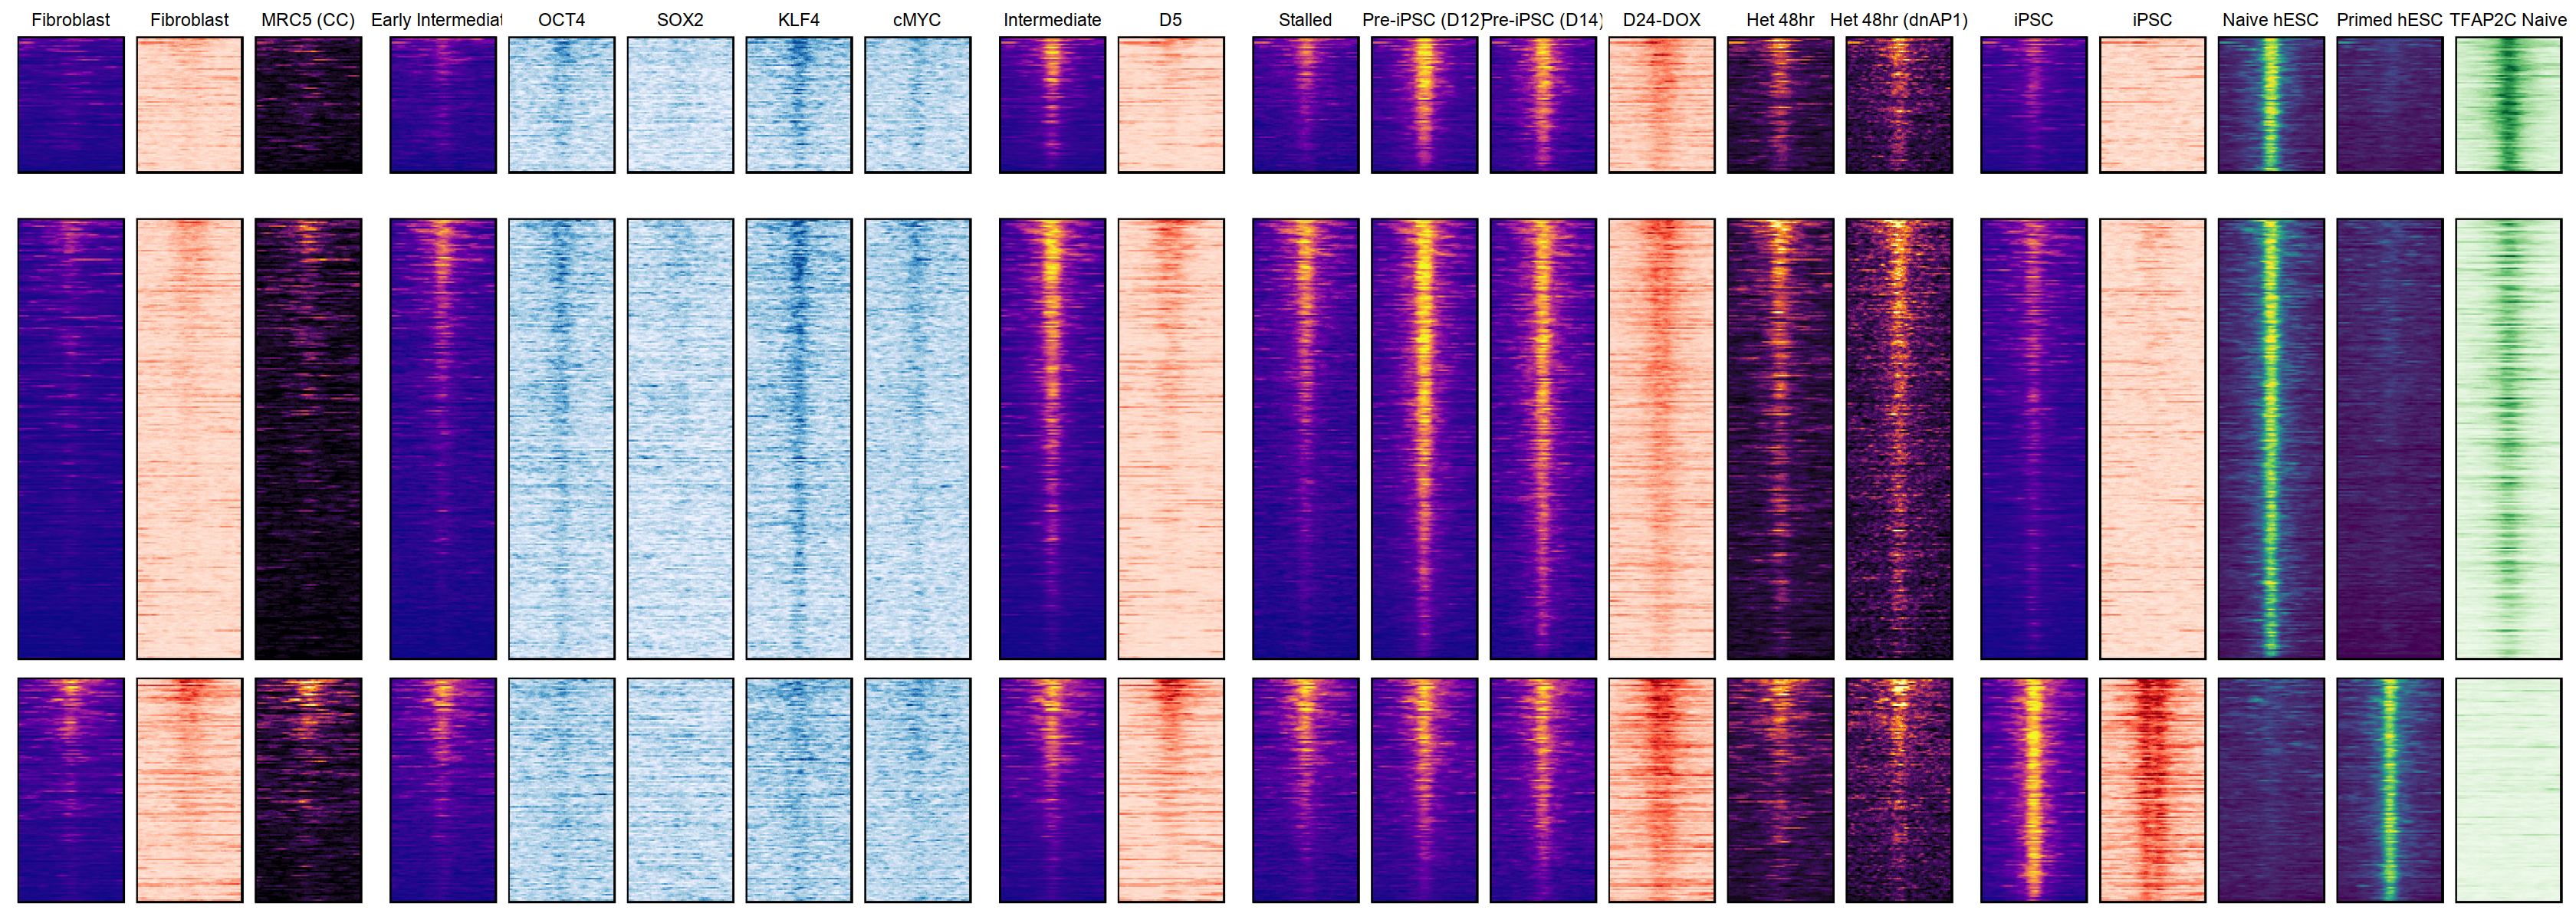

In [125]:
options(repr.plot.width = 28, repr.plot.height = 10)
wrap_plots(
    rowwise_plots,
    ncol=1,
    heights = col_heights)